## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.index.is_monotonic

True

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### Шаги:
    1.Подключены нужные библиотеки и выведена первичная информация
    2.С помощью метода is_monotonic определена последовательность временных значений
    3.Данные ресемплированны по одному часу

### Вывод:
    После ресемплирования осталось 4416 строк данных от изначальных 26496 строк.

# 2. Анализ

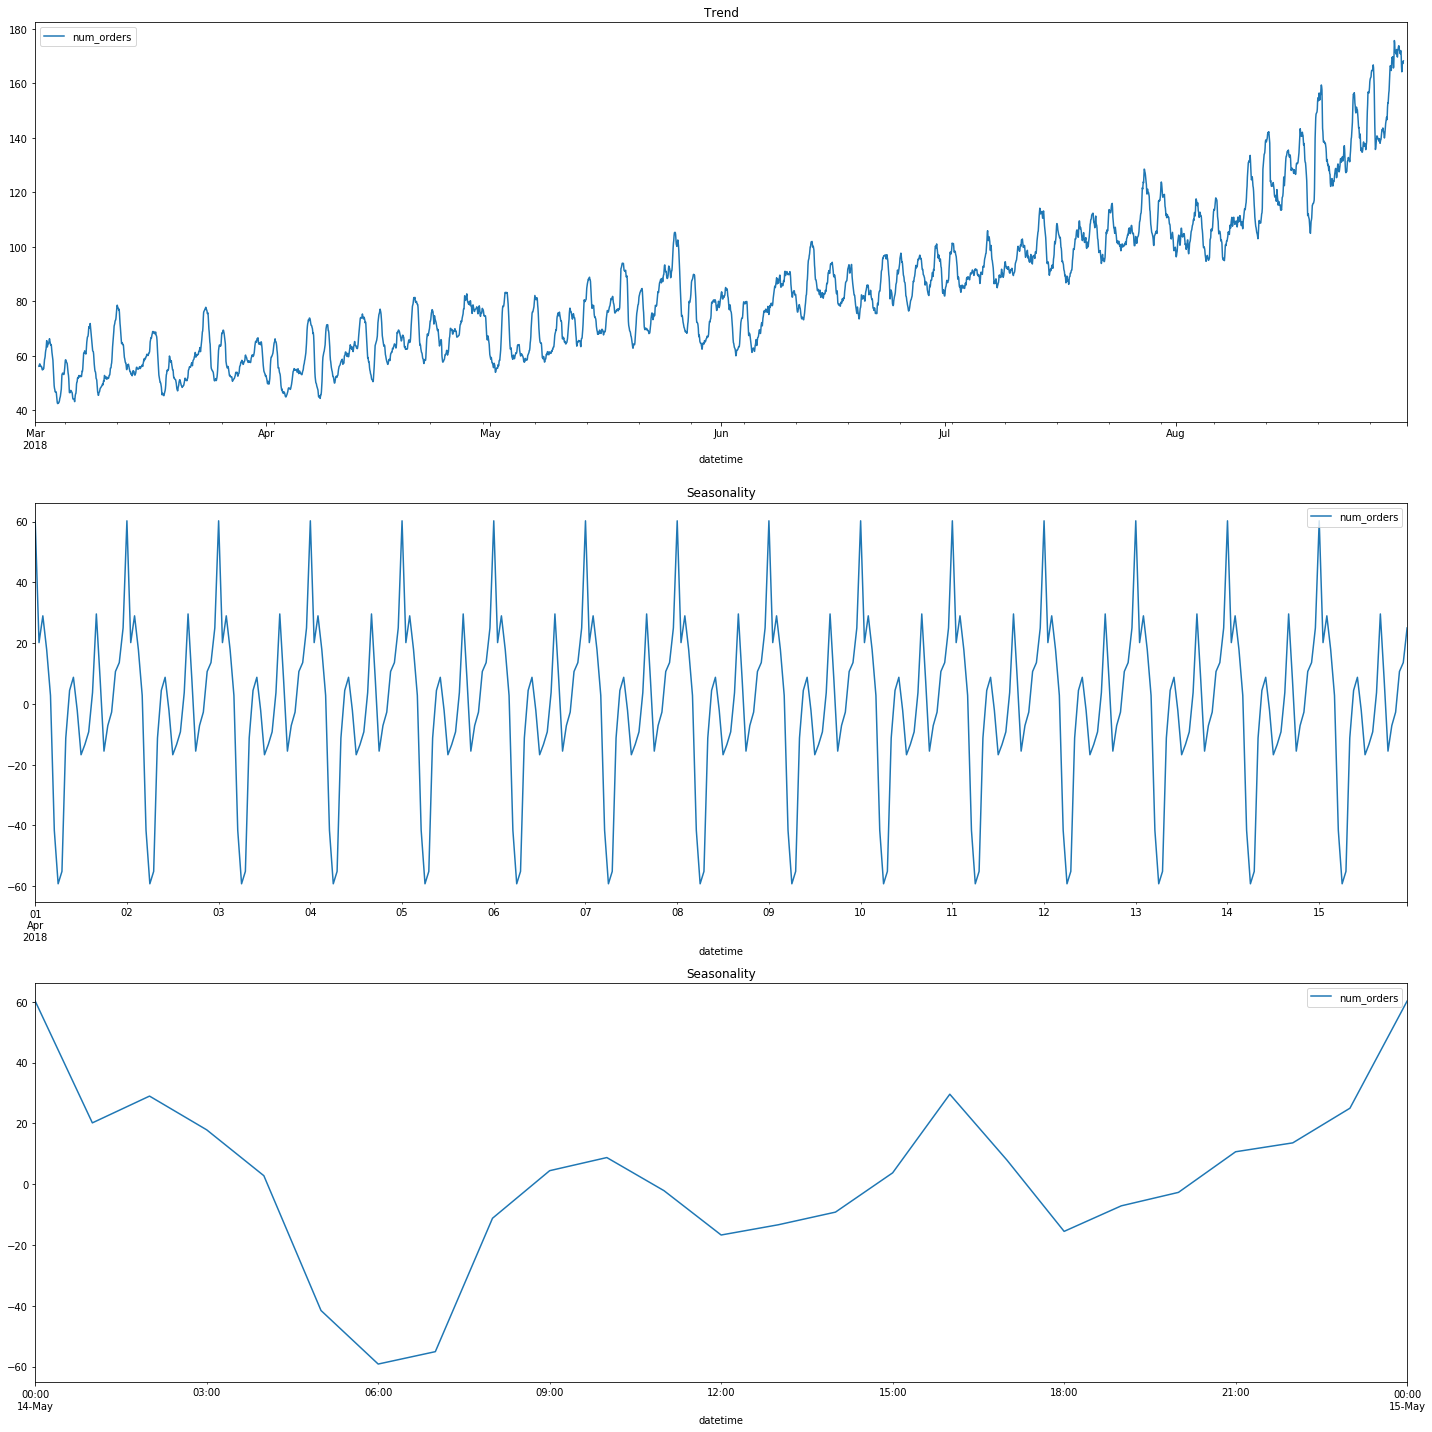

In [ ]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(20, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.seasonal['2018-05-14-00:00:00':'2018-05-15-00:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.tight_layout()

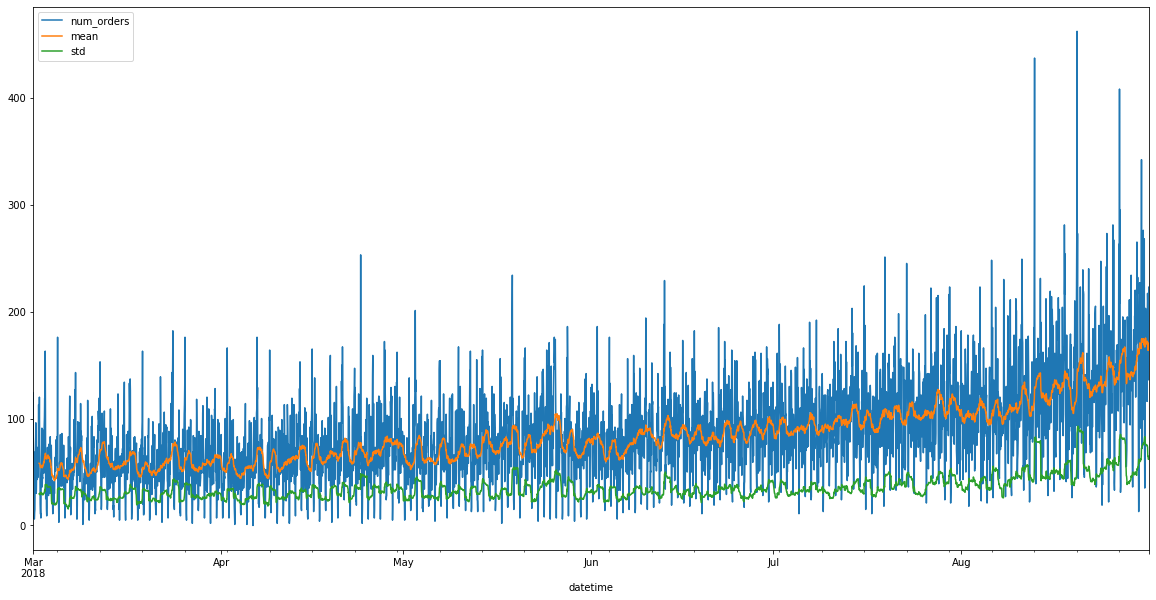

In [ ]:
df_decomposed = df.copy()
df_decomposed['mean'] = df_decomposed['num_orders'].rolling(25).mean()
df_decomposed['std'] = df_decomposed['num_orders'].rolling(25).std()
df_decomposed.plot(figsize=(20, 10))

### Шаги:
    1.Построен график тренда
    2.Построен график сезонности с 2018-04-01 по 2018-04-15
    3.Построен график сезонности на день
    4.Построен график со скользящими средней и дисперсией

### Вывод:
    Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное  время. Также можно сказать, что стохастический процесс нестационарный

# 3. Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['year'] = data.index.year
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 25, 25)

In [ ]:
trains, test = train_test_split(df, shuffle=False, test_size=.1)

In [ ]:
trains = trains.dropna()

In [ ]:
train, valid = train_test_split(trains, shuffle=False, test_size=.2)

In [ ]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis =1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [ ]:
print('Длина обучающей выборки: {:.0%}'.format(len(train) / len(df)))
print('Длина валидационной выборки: {:.0%}'.format(len(valid) / len(df)))
print('Длина тестовой выборки: {:.0%}'.format(len(test) / len(df)))

Длина обучающей выборки: 72%
Длина валидационной выборки: 18%
Длина тестовой выборки: 10%


In [ ]:
def score(model, features_train, features_valid, target_train, target_valid):
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)

    return mean_squared_error(target_valid, predict)**.5

In [ ]:
LGBMRegressor_model = LGBMRegressor()


parametrs = {
    'n_estimators': range(1, 200, 20),
    'max_depth': range(1, 20, 2)
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(LGBMRegressor_model, parametrs, cv=tscv)

grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 3, 'n_estimators': 121}

In [ ]:
LGBMRegressor_model = LGBMRegressor(max_depth=3, n_estimators=121)
LightGBM = score(LGBMRegressor_model, features_train, features_valid, target_train, target_valid)

In [ ]:
CatBoostRegressor_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=10, silent=True, random_state=12345)
CatBoost = score(CatBoostRegressor_model, features_train, features_valid, target_train, target_valid)

In [ ]:
LinearRegression_model = LinearRegression()
LinearRegression = score(LinearRegression_model, features_train, features_valid, target_train, target_valid)

In [ ]:
pd.DataFrame(data=[LightGBM, CatBoost, LinearRegression], 
             index=['LightGBM', 'CatBoost', 'LinearRegression'], columns=['RMSE'])

,RMSE
LightGBM,32.266349
CatBoost,33.929445
LinearRegression,33.336757


### Шаги:
    1.Написана функция для создания признаков
    2.Датасет разделен на обучающую и тестовую выборки
    3.Из обучающей выборки удалены строки с пропусками
    4.Обучающая выборка разделена на тренировочную и валидационную
    5.Во всех выборках выделен целевой признак
    6.Проверены размеры полученных выборок
    7.Написана функция score, которая реализует обучение и предсказание модели
    8.Проведен подбор параметров для модели LGBMRegressor.
    9.Обучена модель LGBMRegressor с тремя параметрами max_depth=3, n_estimators=121
    10.Обучена модель CatBoostRegressor с тремя параметрами iterations=100, learning_rate=0.1, depth=10
    11.Обучена модель LinearRegression

### Вывод:
    LightGBM показал лучший результат на обучающей выборке. На тестовой выборке также попробуем все три модели, возможно какая-то  из моделей могла переобучиться.

# 4. Тестирование

In [ ]:
LightGBM = score(LGBMRegressor_model, features_train, features_test, target_train, target_test)

In [ ]:
CatBoost = score(CatBoostRegressor_model, features_train, features_test, target_train, target_test)

In [ ]:
LinearRegression = score(LinearRegression_model, features_train, features_test, target_train, target_test)

In [ ]:
pd.DataFrame(data=[LightGBM, CatBoost, LinearRegression], 
             index=['LightGBM', 'CatBoost', 'LinearRegression'], columns=['RMSE'])

,RMSE
LightGBM,55.151088
CatBoost,64.948778
LinearRegression,47.416480


### Шаги:
    1.Обучена модель LGBMRegressor на тестовой выборке 
    2.Обучена модель CatBoostRegressor на тестовой выборке 
    3.Обучена модель LinearRegression на тестовой выборке

### Вывод:
    В данном случае модели CatBoost и LightGBM явно переобучены. Более простая модель отработала лучше и дала нужный нам результат RMSE на тестовой выборке меньше 48.